Replication of Ruyi's code.

Dataset: IXI

10% for test, 90% for training. (Option: k-folds cross validation, not implemented yet.)

In [26]:
# main:
!python preprocess.py

---------------------------------------- preprocessing starts ----------------------------------------
| |#                                                | 100 Elapsed Time: 0:00:00
IXI_rename() finished. No file found.
phenotypics.csv exists already.
training.csv and test.csv exist already.
./IXI_npy  exists already!
./IXI_npy/origin  exists already!
./IXI_npy/mean_subtracted  exists already!
| |#                                                | 100 Elapsed Time: 0:00:00
./IXI_npy/mean_npy.npy exists already.
| |#                                                | 100 Elapsed Time: 0:00:00
./training.tfrecords exists already.
./test.tfrecords exists already.
---------------------------------------- preprocessing ends ----------------------------------------


In [23]:

# gen tfrecords:

import tensorflow as tf
import numpy as np
import pdb
import os
import pandas as pd
from progressbar import *


def gen_tfrecord(csv_path_name,npy_dir,tf_filename='tf.tfrecords'):
    '''
    To generate .tfrecord files according to .csv file
    
    csv_path_name: .csv file's path and name
    npy_dir: where are the .npy files
    tf_filename: name of .tfrecords file under ./
    '''
#     pdb.set_trace()
    
    tf_path_name = os.path.join('./',tf_filename)

#     tf_path = os.path.join(data_root,feature_name, 'train' if for_training else 'test')
#     tf_filename = os.path.join(tf_path, '.tfrecords')
    if os.path.exists(tf_path_name):
        print(tf_path_name, 'exists already.')
        return
    print('Writing', tf_path_name)
    with tf.python_io.TFRecordWriter(tf_path_name) as writer:
#         df_name = os.path.join(tf_path,'info.csv')
        info_df = pd.read_csv(csv_path_name, sep=',',header=0)
        id_list = list(info_df['id'])
        age_list = list(info_df['age'])
        n = len(id_list)
        pbar = ProgressBar().start()
        for i,ixi_id in enumerate(id_list):
            str_id = str(int(ixi_id))
            if ixi_id < 10:
                str_id = '00' + str_id
            elif ixi_id > 9 and ixi_id < 100:
                str_id = '0' + str_id
            npy_filename = 'IXI' + str_id + '.npy'
            npy_path_filename = os.path.join(npy_dir,npy_filename)
            try:
                arr_npy = np.load(npy_path_filename)
            except FileNotFoundError:
                print('No such file: ',npy_filename)
                continue
                
#             pdb.set_trace()
            label = round(age_list[i],2)
            arr = arr_npy.astype(np.float32)
            arr_raw = arr.tostring()
            example = tf.train.Example(
                features = tf.train.Features(
                    feature = {
                        'arr_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[arr_raw])),
                        'label': tf.train.Feature(float_list=tf.train.FloatList(value=[label]))
                    }
                )
            )
            writer.write(example.SerializeToString())
            pbar.update(int(i*100/(n-1)))
        pbar.finish()

if __name__ == '__main__':
    gen_tfrecord('./training.csv',npy_dir='./IXI_npy/mean_subtracted/',tf_filename='training.tfrecords')
    gen_tfrecord('./test.csv',npy_dir='./IXI_npy/mean_subtracted/',tf_filename='test.tfrecords')



/ |#                                                  | 0 Elapsed Time: 0:00:00

Writing ./training.tfrecords


\ |                                    #             | 75 Elapsed Time: 0:01:36

No such file:  IXI628.npy


| |                        #                        | 100 Elapsed Time: 0:02:09
| | #                                                | 29 Elapsed Time: 0:00:00

Writing ./test.tfrecords
No such file:  IXI580.npy


| |     #                                           | 100 Elapsed Time: 0:00:00


In [16]:
import pandas as pd
import tensorflow as tf
df = pd.read_csv('./test.csv')
for i in df:
    print(i)
id_list = list(df['id'])
age_list = list(df['age'])
print(id_list[:5])
print(age_list[:5])
round(age_list[1],2)
tf.train.FloatList?

age
id
[461.0, 580.0, 625.0, 565.0, 207.0]
[60.895277207392205, 24.314852840520192, 47.0691307323751, 63.81656399726214, 40.36139630390144]


In [36]:

from preprocess import *
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import argparse
import sys


FLAGS = None


def print_activations(t):
    print(t.op.name, ' ', t.get_shape().as_list())

def inference(X, keep_prob, is_training_forBN, trivial=True):
    l2_loss = 0
    with tf.name_scope('l1_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([5,5,5,1,FLAGS.sizeof_kernel_1], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[FLAGS.sizeof_kernel_1]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(X,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l2_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,FLAGS.sizeof_kernel_1,32], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[32]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l3_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,32,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l4_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,64,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l5_conv3d') as scope:  # temp
        w = tf.Variable(tf.truncated_normal([3,3,3,64,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l5_fc') as scope:
        max_pool_shape = max_pool.get_shape().as_list()
        temp_shape = 1
        for i in max_pool_shape[1:]:
            temp_shape *= i
        fc_input = tf.reshape(max_pool, [-1, temp_shape])
        w = tf.Variable(tf.truncated_normal([temp_shape,512],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[512]),name='b')
        temp_output = tf.matmul(fc_input,w) + b
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        fc_out = tf.nn.relu(temp_output, name='fc_out')
        
        l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(fc_out)
    with tf.name_scope('l6_fc') as scope:
        max_pool_shape = max_pool.get_shape().as_list()
        temp_shape = 1
        for i in max_pool_shape[1:]:
            temp_shape *= i
        fc_input = tf.reshape(max_pool, [-1, temp_shape])
        w = tf.Variable(tf.truncated_normal([temp_shape,512],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[512]),name='b')
        temp_output = tf.matmul(fc_input,w) + b
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        fc_out = tf.nn.relu(temp_output, name='fc_out')
        dropout = tf.nn.dropout(fc_out,keep_prob=keep_prob, name='dropout')
        
        l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(fc_out)
            print_activations(dropout)
    with tf.name_scope('l7_fc') as scope:
        w = tf.Variable(tf.truncated_normal([512,1],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[1]),name='b')
        
        final_output = tf.add(tf.matmul(dropout,w), b, name='final_output')
        
        l2_loss += tf.nn.l2_loss(w)

        if trivial:
            print_activations(final_output)
    
    return final_output, l2_loss
        
def get_loss(predict_batches,label_batches,l2_loss):
    with tf.name_scope('cross_entropy'):
        cost = tf.reduce_mean(tf.square(predict_batches - label_batches)) + FLAGS.l2_epsilon * l2_loss
    return cost

def get_accuracy(predicts,labels):
    with tf.name_scope('acc'):
#         acc = tf.contrib.metrics.streaming_pearson_correlation(predicts, tf.cast(labels,tf.float32))[0]
        acc = tf.constant(0)
    return acc



def trainning(loss):
    '''
    The weird things are for Batch Normalization.
    '''
#     train_op = tf.train.RMSPropOptimizer(lr,0.9).minimize(loss)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)
    return train_op      


    

def decode(serialized_example):
    features = tf.parse_single_example(
        serialized_example,
        features={
            'arr_raw':tf.FixedLenFeature([],tf.string),
            'label': tf.FixedLenFeature([],tf.float32),
        }
    )
    arr = tf.decode_raw(features['arr_raw'],tf.float32)
    arr = tf.reshape(arr,list(FLAGS.arr_shape))
#     arr = tf.cast(arr,tf.int32)
#     label = tf.cast(features['label'],tf.int32)
    label = features['label']
    
    return arr,label


def get_iterator(for_training=True,num_epochs=1):
    if not num_epochs:
        num_epochs = None
    root_dir = FLAGS.root_dir
    filename = os.path.join(root_dir,('training' if for_training else 'test')+'.tfrecords')

    with tf.name_scope('input'):
        dataset = tf.data.TFRecordDataset(filename)
#         pdb.set_trace()
        dataset = dataset.map(decode)
        if for_training:
            dataset = dataset.repeat(num_epochs)
        dataset = dataset.batch(FLAGS.batch_size)
        if for_training:
            train_iterator = dataset.make_one_shot_iterator()
            val_iterator = dataset.make_one_shot_iterator()
            iterators = [train_iterator,val_iterator]
        else:
            test_iterator = dataset.make_initializable_iterator()
            iterators = [test_iterator]

        
    return iterators

    
def run_training():
    with tf.Graph().as_default():
        num_epochs = FLAGS.num_epochs
        iterators = get_iterator(num_epochs=num_epochs)
        handle = tf.placeholder(tf.string,shape=[])
        iterator = tf.data.Iterator.from_string_handle(handle, iterators[0].output_types)
        arr_batch,label_batch = iterator.get_next()
        
#         pdb.set_trace()

        X = tf.reshape(arr_batch, [-1]+list(FLAGS.arr_shape)+[1])
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
        is_training_forBN = tf.placeholder(tf.bool, name='is_training_forBN')
        
        predicted_age,l2_loss = inference(X,keep_prob,is_training_forBN)

        loss = get_loss(predicted_age,label_batch,l2_loss)
        acc = get_accuracy(predicted_age,label_batch)
    
        train_op = trainning(loss)
    
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
    
        saver = tf.train.Saver()

    
        with tf.Session() as sess:
            losses = []
            acces = []
            steps = []
            
            test_losses = []
            test_acces = []
            test_steps = []
            
#             pdb.set_trace()
            sess.run(init_op)
            train_iterator_handle = sess.run(iterators[0].string_handle())
            val_iterator_handle = sess.run(iterators[1].string_handle())
            
            test_iterator = get_iterator(for_training=False)[0]
            test_iterator_handle = sess.run(test_iterator.string_handle())
            
            print('Let\'s get started to train!')
            
            try:
                step = 0
                min_test_loss = 100.0
                while True:
                    start_time = time.time()
                    train_a,train_l,_ = sess.run([arr_batch,label_batch,train_op],
                                                  feed_dict={keep_prob:0.5,
                                                             is_training_forBN:True,
                                                            handle:train_iterator_handle})

                    val_a,val_l,acc_value,loss_value = sess.run([arr_batch,label_batch,acc,loss],
                                                                feed_dict={keep_prob:1.0,
                                                                           is_training_forBN:False,
                                                                          handle:val_iterator_handle})
                    duration = time.time() - start_time

                    if step % 100 == 0:
                        sess.run(test_iterator.initializer)
                        test_predicted_ages = []
                        test_labels = []
                        test_l2_losses = 0
                        try:
                            while True:
                                test_predicted_age,test_label,test_l2_loss = sess.run([predicted_age,label_batch,l2_loss],
                                                                feed_dict={keep_prob:1.0,
                                                                           is_training_forBN:False,
                                                                          handle:test_iterator_handle})
#                                 pdb.set_trace()
                                test_predicted_ages.append(test_predicted_age)
                                test_labels.append(test_label)
                                test_l2_losses += test_l2_loss
                        except tf.errors.OutOfRangeError:
#                             pdb.set_trace()
                            test_predicted_ages = np.concatenate(tuple(test_predicted_ages))
                            test_labels = np.concatenate(tuple(test_labels))
                            test_loss = (get_loss(test_predicted_ages,test_labels,test_l2_losses)).eval()
                            test_acc = (get_accuracy(test_predicted_ages,test_labels)).eval()
                            test_losses.append(test_loss)
                            test_acces.append(test_acc)
                            test_steps.append(step)
                            print('Step %d: training_loss = %.2f (%.3f sec)\n (val_loss)test_loss = %.2f' 
                                  %(step,loss_value,duration,test_loss))
                            
                            if test_loss < min_test_loss:
                                min_test_loss = test_loss
                                print('best shot model: test_loss = %.2f, step = %d' %(min_test_loss,step))
                                if step > 100:
                                    save_path = saver.save(sess, FLAGS.saver_dir)
                                    print('model saved successfully.')
                                    
                    steps.append(step)
                    acces.append(acc_value)
                    losses.append(loss_value)
                    step += 1
            except tf.errors.OutOfRangeError:
                print('Done training for %d epochs, %d steps.' %(num_epochs,step))
            

            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
            ax1.plot(steps, losses)
            ax1.plot(test_steps,test_losses)
            ax1.set_title('trainning loss')
            ax2.plot(steps, acces)
            ax2.plot(test_steps,test_acces)
            ax2.set_title('trainning acc')
            ax1.grid(True)
            ax2.grid(True)
    return
 
    
def run_test():
    with tf.Graph().as_default():
        handle = tf.placeholder(tf.string,shape=[])
        test_iterator = get_iterator(for_training=False)[0]
        iterator = tf.data.Iterator.from_string_handle(handle, test_iterator.output_types)
        arr_batch,label_batch = iterator.get_next()
        X = tf.reshape(arr_batch, [-1]+list(FLAGS.arr_shape)+[1])
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
        is_training_forBN = tf.placeholder(tf.bool, name='is_training_forBN')
        
        predicted_age,l2_loss = inference(X,keep_prob,is_training_forBN)

        loss = get_loss(predicted_age,label_batch,l2_loss)
        acc = get_accuracy(predicted_age,label_batch)
    
        saver = tf.train.Saver()
#         pdb.set_trace()
        with tf.Session() as sess:
            saver.restore(sess, FLAGS.saver_dir)
            print('Model loaded successfully.')
            test_iterator_handle = sess.run(test_iterator.string_handle())
            sess.run(test_iterator.initializer)
            test_predicted_ages = []
            test_labels = []
            test_l2_losses = 0
            try:
                while True:
                    test_predicted_age,test_label, test_l2_loss = sess.run([predicted_age, label_batch, l2_loss],
                                                    feed_dict={keep_prob:1.0,
                                                               is_training_forBN:False,
                                                              handle:test_iterator_handle})
                    test_predicted_ages.append(test_softmax_in)
                    test_labels.append(test_label)
                    test_l2_losses += test_l2_loss
            except tf.errors.OutOfRangeError:
                test_predicted_ages = np.concatenate(tuple(test_predicted_ages))
                test_labels = np.concatenate(tuple(test_labels))
                
                test_loss = (get_loss(test_predicted_ages,test_labels, test_l2_losses)).eval()
                test_acc = (get_accuracy(test_predicted_ages,test_labels)).eval()
                
                print('test_loss = %.2f, test_accuracy = %.2f.' 
                                  %(test_loss,test_acc))
            plt.title('Test Data')
            plt.xlabel('Chronological Age')
            plt.ylabel('Brain Age (Predicted)')
            plt.xlim(0, 100)
            plt.ylim(0, 100)
            for i in range(len(test_labels)):
                plt.scatter(test_labels[i], test_predicted_ages[i], c = 'blue',s=1)
            plt.gca().set_aspect('equal', adjustable='box')
    return


def main(_):
#     pdb.set_trace()
    arr = np.load('./IXI_npy/mean_npy.npy')
    FLAGS.arr_shape = arr.shape
    
    run_training()
    run_test()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--saver_dir',
                       type=str,
                       default="./log/demo6_model.ckpt",
                       help='Directory to save checkpoint.')
    parser.add_argument('--l2_epsilon',
                       type=float,
                       default=1e-6,
                       help='L2 regularization parameter.')
    parser.add_argument('--root_dir',
                       type=str,
                       default='./',
                       help='Where is the tfrecord file.')
    parser.add_argument('--sizeof_kernel_1',
                        type=int,
                        default=16,
                        help='kernel size of 1st hidden layer.')
    parser.add_argument('--batch_size',
                        type=int,
                        default=10,
                        help='Batch size.')
#     parser.add_argument(
#       '--learning_rate',
#       type=float,
#       default=0.01,
#       help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=100,
                        help='Number of epochs to run trainer.')
#     parser.add_argument(
#       '--hidden1',
#       type=int,
#       default=128,
#       help='Number of units in hidden layer 1.')
#     parser.add_argument(
#       '--hidden2',
#       type=int,
#       default=32,
#       help='Number of units in hidden layer 2.')

#     parser.add_argument(
#       '--train_dir',
#       type=str,
#       default='/tmp/data',
#       help='Directory with the training data.')
    FLAGS, unparsed = parser.parse_known_args()
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

l1_conv3d/Relu   [None, 130, 130, 110, 16]
l1_conv3d/max_pool3d   [None, 65, 65, 55, 16]
l2_conv3d/Relu   [None, 65, 65, 55, 32]
l2_conv3d/max_pool3d   [None, 33, 33, 28, 32]
l3_conv3d/Relu   [None, 33, 33, 28, 64]
l3_conv3d/max_pool3d   [None, 17, 17, 14, 64]
l4_conv3d/Relu   [None, 17, 17, 14, 64]
l4_conv3d/max_pool3d   [None, 9, 9, 7, 64]
l5_conv3d/Relu   [None, 9, 9, 7, 64]
l5_conv3d/max_pool3d   [None, 5, 5, 4, 64]
l5_fc/fc_out   [None, 512]
l6_fc/fc_out   [None, 512]
l6_fc/dropout/mul   [None, 512]
l7_fc/final_output   [None, 1]
Let's get started to train!
Step 0: training_loss = 5956694.00 (1.217 sec)
 (val_loss)test_loss = 1566996.25
Step 100: training_loss = 2180.79 (0.725 sec)
 (val_loss)test_loss = 2207.31
Step 200: training_loss = 2600.89 (0.725 sec)
 (val_loss)test_loss = 2023.67
Step 300: training_loss = 2151.16 (0.728 sec)
 (val_loss)test_loss = 1886.05
Step 400: training_loss = 2602.74 (0.731 sec)
 (val_loss)test_loss = 1690.17


KeyboardInterrupt: 

In [ ]:




npy_img = np.load('./IXI_npy/mean_npy.npy')
npy_img = np.load('./IXI_npy/mean_subtracted/IXI002.npy')
npy_img = np.load('./IXI_npy/origin/IXI002.npy')
print(npy_img.shape)
# plt.imshow(npy_img[:,:,60])
print_2d(npy_img)


(130, 130, 110)


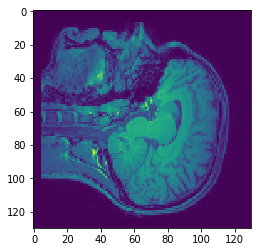

In [331]:
npy_img = np.load('./IXI_npy/origin/IXI012.npy')
print(npy_img.shape)
plt.imshow(npy_img[:,:,60])
# plt.imshow(npy_img[:,60,:])
# plt.imshow(npy_img[60,:,:])

In [298]:
a = np.random.randint(10,size=(3,3))
b = np.random.randint(10,size=(3,3))
c = np.random.randn(3,3)
print(c)
# a += 1
# print(a)
cc = c.astype(int)
print(cc.dtype)
# print(c)
# print(c)
# c.astype(int)
# preprocess_1('IXI002-Guys-0828-T1.nii.gz')

[[ 0.64556574 -0.11930629 -0.55652819]
 [-0.45738679 -0.15989128  0.69457218]
 [-0.2875507   0.19856827  0.58267735]]
int64


In [287]:
10/3

3.3333333333333335

In [ ]:
a = np.random.randint

In [193]:
phenotypics = pd.read_csv('./phenotypics.csv', sep=',',header=0)
# print(phenotypics)
phenotypics[5:10]

,age,id
5,68.134155,473.0
6,44.991102,287.0
7,45.295003,588.0
8,62.455852,392.0
9,66.015058,603.0


| |#                                                | 100 Elapsed Time: 0:00:00
| |#                                                | 100 Elapsed Time: 0:00:00
| |#                                                | 100 Elapsed Time: 0:00:00


IXI_rename() finished. No file found.
phenotypics.csv exists already.
training.csv and test.csv exist already.
./IXI_npy  exists already!
./IXI_npy/origin  exists already!
mean_npy.npy exists already.
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename
target_filename

In [137]:
!cd /media/woody/Elements/age_data/IXI/IXI-T1/

os.path.exists('/media/woody/Elements/age_data/IXI/IXI-T1/IXI.*-.*-.*-T1\.nii\.gz$')

False

In [159]:
import time
from progressbar import *

# for i in range(10):
#     print('\r'+str((i+1)*100.0/10)+'%',end='',flush=True)
#     time.sleep(0.3)
# print('abc')

pbar = ProgressBar().start()
for i in range(10):
    pbar.update(int(i*100/(10-1)))
    time.sleep(0.8)
pbar.finish()

| |                 #                               | 100 Elapsed Time: 0:00:08


In [178]:
import time
from progressbar import *
total = 100
def dosomework():
    time.sleep(0.01)
widgets = ['Progress: ',Percentage(), ' ', Bar('>'),' ', Timer(),
      ' ', ETA()]
pbar = ProgressBar(widgets=widgets, maxval=total+100).start()
for i in range(total):
    # do something
    pbar.update(i)
    dosomework()
pbar.finish()

Progress: 100% |>>>>>>>>>>>>>>>>>>>>>>>>>| Elapsed Time: 0:00:01 Time:  0:00:01


In [175]:
ProgressBar?

In [161]:
  
import sys, time  
from progressbar import *  
  
total = 1000  
  
def dosomework():  
    time.sleep(0.01)  
pbar = ProgressBar().start()  
for i in range(1000):  
    pbar.update(int((i / (total - 1)) * 100))  
    dosomework()  
pbar.finish()  

| |       #                                         | 100 Elapsed Time: 0:00:10


In [16]:
data = xlrd.open_workbook('IXI.xls','rb')
print('工作表名为：'+ data.sheet_names()[0])
table = data.sheets()[0]
nrows = table.nrows
ncols = table.ncols
print('表格行数为%d,列数为%d'%(nrows,ncols))

#输出每一行的值
# for item in range(table.nrows):
#     print(table.row_values(item))

#获取单元格的值
cell_A1 = table.row(0)[0].value
cell_A2 = table.cell(0,0).value
cell_A3 = table.col(0)[0].value

print(cell_A1)
print(cell_A2)
print(cell_A3)

工作表名为：Table
表格行数为620,列数为12
IXI_ID
IXI_ID
IXI_ID
